<a href="https://colab.research.google.com/github/asgharlaib/Project_v1/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
full_df = pd.read_csv("/content/drive/MyDrive/CC_LCL-FullData.csv")
full_df.head(n=10)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0
5,MAC000002,Std,2012-10-12 03:00:00.0000000,0
6,MAC000002,Std,2012-10-12 03:30:00.0000000,0
7,MAC000002,Std,2012-10-12 04:00:00.0000000,0
8,MAC000002,Std,2012-10-12 04:30:00.0000000,0
9,MAC000002,Std,2012-10-12 05:00:00.0000000,0


In [4]:
full_df_copy = full_df.copy()

In [5]:
print(f"full_df columns datatypes: {full_df.dtypes} \n")

full_df columns datatypes: LCLid                      object
stdorToU                   object
DateTime                   object
KWH/hh (per half hour)     object
dtype: object 



In [6]:
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])

print(f"full_df columns datatypes: {full_df.dtypes} \n")

full_df columns datatypes: LCLid                              object
stdorToU                           object
DateTime                   datetime64[ns]
KWH/hh (per half hour)             object
dtype: object 



In [7]:
# Convert the 'DateTime' column to datetime type
full_df['DateTime'] = pd.to_datetime(full_df['DateTime'])

# Extract the date and time into separate columns
full_df['Date'] = full_df['DateTime'].dt.date
full_df['Time'] = full_df['DateTime'].dt.time

# Display the first few rows to verify
print(full_df.head())

       LCLid stdorToU            DateTime KWH/hh (per half hour)         Date  \
0  MAC000002      Std 2012-10-12 00:30:00                      0   2012-10-12   
1  MAC000002      Std 2012-10-12 01:00:00                      0   2012-10-12   
2  MAC000002      Std 2012-10-12 01:30:00                      0   2012-10-12   
3  MAC000002      Std 2012-10-12 02:00:00                      0   2012-10-12   
4  MAC000002      Std 2012-10-12 02:30:00                      0   2012-10-12   

       Time  
0  00:30:00  
1  01:00:00  
2  01:30:00  
3  02:00:00  
4  02:30:00  


In [8]:
full_df.set_index('DateTime', inplace=True)

In [ ]:
non_numeric_values = df_8am[~df_8am['KWH/hh (per half hour) '].apply(lambda x: pd.to_numeric(x, errors='coerce')).notnull()]

print(non_numeric_values)

NameError: name 'df_8am' is not defined

In [9]:
full_df['KWH/hh (per half hour) '] = pd.to_numeric(full_df['KWH/hh (per half hour) '], errors='coerce')
full_df.columns

Index(['LCLid', 'stdorToU', 'KWH/hh (per half hour) ', 'Date', 'Time'], dtype='object')

In [10]:
full_df_daily = full_df.groupby(['Date', 'stdorToU', 'LCLid']).agg({'KWH/hh (per half hour) ': 'mean'}).reset_index()
full_df_daily.head(15)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,Std,MAC000145,0.298400
1,2011-11-23,Std,MAC000148,0.045821
2,2011-11-23,Std,MAC000149,0.081679
3,2011-11-23,Std,MAC000150,0.330500
4,2011-11-23,Std,MAC000151,0.125885
5,2011-11-23,Std,MAC000152,0.248708
6,2011-11-23,Std,MAC000153,0.904250
7,2011-11-23,Std,MAC000154,0.252087
8,2011-11-23,Std,MAC000155,0.421864
9,2011-11-23,Std,MAC000156,0.296500


In [11]:
##Descriptive Analysis
#Dataframe column names
print(f"Column names: {list(full_df_daily.columns)} \n")

#Dataframe shape
print(f"full_df_daily shape: {full_df_daily.shape} \n")

#Dataframe datatypes
print(f"full_df_daily columns datatypes: {full_df_daily.dtypes} \n")

#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

Column names: ['Date', 'stdorToU', 'LCLid', 'KWH/hh (per half hour) '] 

full_df_daily shape: (3510433, 4) 

full_df_daily columns datatypes: Date                        object
stdorToU                    object
LCLid                       object
KWH/hh (per half hour)     float64
dtype: object 

missing values: Date                        0
stdorToU                    0
LCLid                       0
KWH/hh (per half hour)     30
dtype: int64 



In [12]:
nan_indices = full_df_daily[full_df_daily['KWH/hh (per half hour) '].isnull()].index
print(nan_indices)

Index([1195182, 1195194, 1195362, 1195706, 1195768, 1195835, 1195877, 1195893,
       1195921, 1196159, 1196419, 1196467, 1196573, 1196663, 1198894, 1199131,
       1199695, 1204800, 1204801, 1204802, 1204803, 1204806, 1205924, 1292638,
       1473512, 1510748, 1635224, 1847172, 2685308, 2887981],
      dtype='int64')


In [13]:
full_df_daily['KWH/hh (per half hour) '].fillna(full_df_daily['KWH/hh (per half hour) '].mean(skipna=True), inplace=True)
full_df_daily.head(15)

,Date,stdorToU,LCLid,KWH/hh (per half hour)
0,2011-11-23,Std,MAC000145,0.298400
1,2011-11-23,Std,MAC000148,0.045821
2,2011-11-23,Std,MAC000149,0.081679
3,2011-11-23,Std,MAC000150,0.330500
4,2011-11-23,Std,MAC000151,0.125885
5,2011-11-23,Std,MAC000152,0.248708
6,2011-11-23,Std,MAC000153,0.904250
7,2011-11-23,Std,MAC000154,0.252087
8,2011-11-23,Std,MAC000155,0.421864
9,2011-11-23,Std,MAC000156,0.296500


In [14]:
#Looking for missing values
print(f"missing values: {full_df_daily.isnull().sum()} \n")

missing values: Date                       0
stdorToU                   0
LCLid                      0
KWH/hh (per half hour)     0
dtype: int64 



In [15]:
##Descriptive Statistics
full_df_daily.describe()

,KWH/hh (per half hour)
count,3.510433e+06
mean,2.117101e-01
std,1.908393e-01
min,0.000000e+00
25%,9.806250e-02
50%,1.632708e-01
75%,2.624375e-01
max,6.928250e+00


Text(0.5, 1.0, 'Standard vs Dynamic Time of Use Distribution')

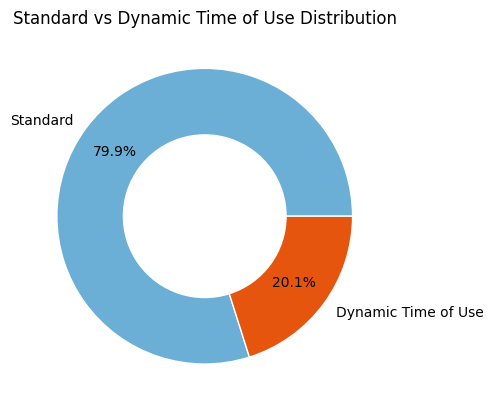

In [16]:
# EDA: Pie chart:
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap([1,4])
inner_colors = cmap([7,8,7,8])
size = 0.45
pctdist = 0.75

# Counts of households in std or ToU pricing Scheme
total_number = full_df_daily['stdorToU'].value_counts()

# Pie Chart to show distribution
ax.pie(
    np.array(total_number),
    autopct='%1.1f%%',
    pctdistance = pctdist,
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['Standard','Dynamic Time of Use']
);
plt.title("Standard vs Dynamic Time of Use Distribution")


         Date stdorToU      LCLid  KWH/hh (per half hour) 
0  2011-11-23      Std  MAC000145                 0.298400
1  2011-11-23      Std  MAC000148                 0.045821
2  2011-11-23      Std  MAC000149                 0.081679
3  2011-11-23      Std  MAC000150                 0.330500
4  2011-11-23      Std  MAC000151                 0.125885
          Date stdorToU      LCLid  KWH/hh (per half hour) 
11  2011-11-23      ToU  MAC000146                 0.187300
12  2011-11-23      ToU  MAC000147                 0.108429
34  2011-11-24      ToU  MAC000146                 0.178417
35  2011-11-24      ToU  MAC000147                 0.156021
36  2011-11-24      ToU  MAC000158                 0.106033


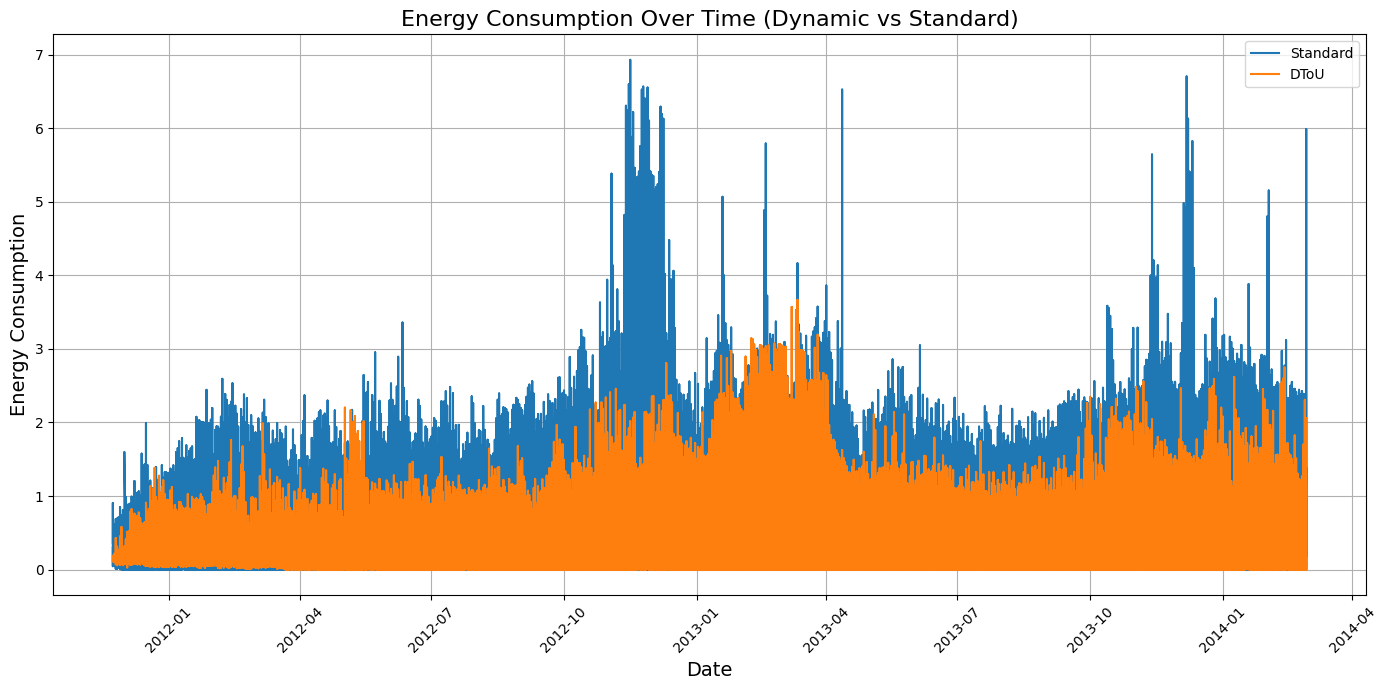

In [19]:
# Filter for dynamic and standard pricing
df_dynamic = full_df_daily[full_df_daily['stdorToU'] == 'ToU']
df_standard = full_df_daily[full_df_daily['stdorToU'] == 'Std']

print(df_standard.head())
print(df_dynamic.head())
# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df_standard['Date'], df_standard['KWH/hh (per half hour) '], label='Standard')
plt.plot(df_dynamic['Date'], df_dynamic['KWH/hh (per half hour) '], label='DToU')
# Formatting the plot
plt.title('Energy Consumption Over Time (Dynamic vs Standard)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [23]:
quantile1 = full_df_daily['KWH/hh (per half hour) '].quantile(0.25)
quantile3 = full_df_daily['KWH/hh (per half hour) '].quantile(0.75)
Inter_quartile_range = quantile3 - quantile1
lower_bound = quantile1 - 1.5 * Inter_quartile_range
upper_bound = quantile3 + 1.5 * Inter_quartile_range

In [35]:
full_df_daily['log_KWH'] = np.log(full_df_daily['KWH/hh (per half hour) '])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


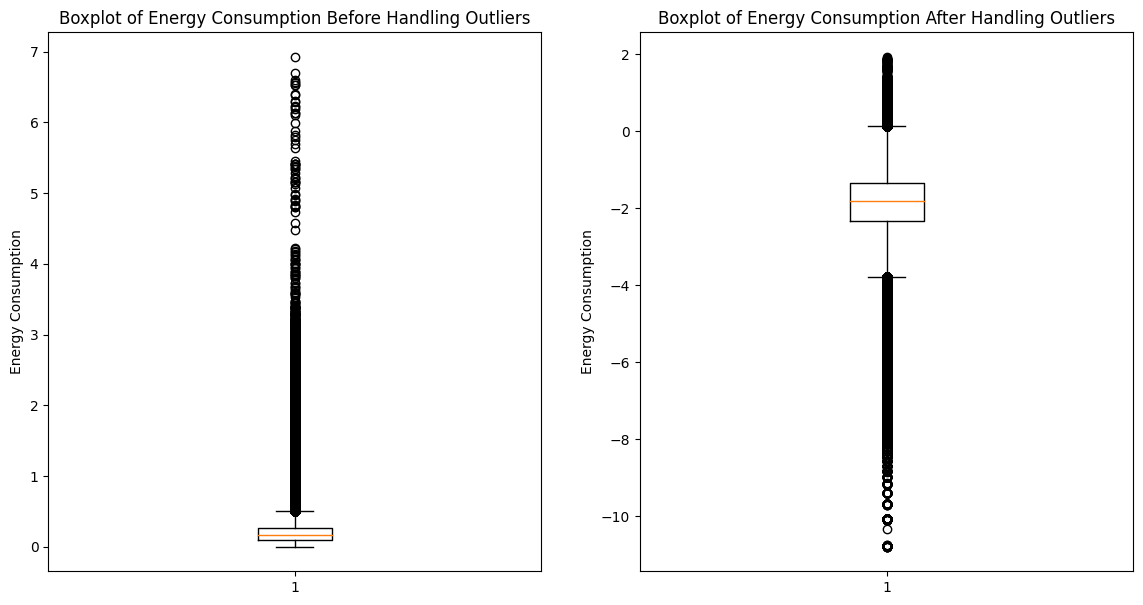

In [36]:
plt.figure(figsize=(14, 7))

plt.subplot(1,2,1)
plt.boxplot(full_df_daily['KWH/hh (per half hour) '])
plt.title('Boxplot of Energy Consumption Before Handling Outliers')
plt.ylabel('Energy Consumption')

plt.subplot(1,2,2)
plt.boxplot(full_df_daily['log_KWH'])
plt.title('Boxplot of Energy Consumption After Handling Outliers')
plt.ylabel('Energy Consumption')
plt.show()

In [21]:
# Function to preprocess the data for LSTM
def preprocess_data(df, time_step):
    data = df['KWH/hh (per half hour) '].values
    data = data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [22]:
# Preprocess the data
time_step = 8  # number of previous timesteps to use for prediction
X_dynamic, y_dynamic, scaler_dynamic = preprocess_data(df_dynamic, time_step)
X_standard, y_standard, scaler_standard = preprocess_data(df_standard, time_step)

# Split the data into training and testing sets
X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dynamic, y_dynamic, test_size=0.2, random_state=42)
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_standard, y_standard, test_size=0.2, random_state=42)

In [ ]:
# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(input_shape[1], input_shape[2])))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [ ]:
# Build and train the model for dynamic TOU
model_dynamic = build_lstm_model(X_train_dyn.shape)
history_dynamic = model_dynamic.fit(X_train_dyn, y_train_dyn, batch_size=1, epochs=1)

# Build and train the model for standard users
model_standard = build_lstm_model(X_train_std.shape)
history_standard = model_standard.fit(X_train_std, y_train_std, batch_size=1, epochs=1)

2468/2468 [==============================] - 13s 4ms/step - loss: 0.0029


In [ ]:
# Make predictions
pred_dynamic = model_dynamic.predict(X_test_dyn)
pred_standard = model_standard.predict(X_test_std)

20/20 [==============================] - 1s 3ms/step


In [ ]:
pred_dynamic = scaler_dynamic.inverse_transform(pred_dynamic)
y_test_dyn = scaler_dynamic.inverse_transform(y_test_dyn.reshape(-1, 1))

pred_standard = scaler_standard.inverse_transform(pred_standard)
y_test_std = scaler_standard.inverse_transform(y_test_std.reshape(-1, 1))

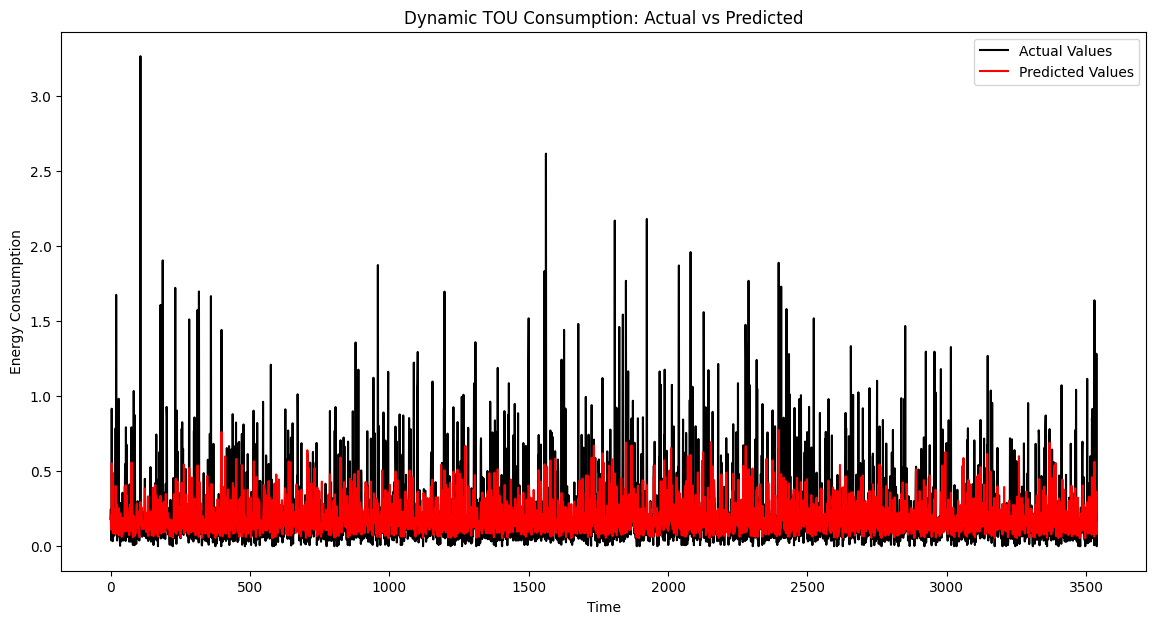

In [ ]:
# Plot the predictions vs actual values for dynamic TOU users
plt.figure(figsize=(14, 7))
plt.plot(y_test_dyn, color='black', label='Actual Values')
plt.plot(pred_dynamic, color='red', label='Predicted Values')
plt.title('Dynamic TOU Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

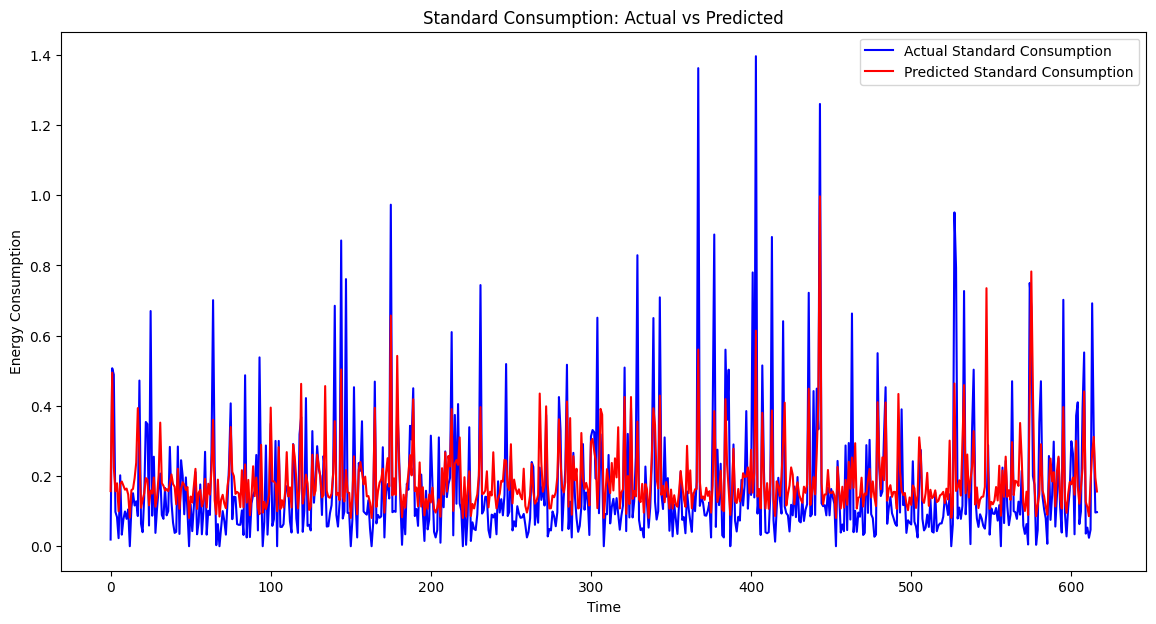

In [ ]:
# Plot the predictions vs actual values for standard users
plt.figure(figsize=(14, 7))
plt.plot(y_test_std, color='blue', label='Actual Standard Consumption')
plt.plot(pred_standard, color='red', label='Predicted Standard Consumption')
plt.title('Standard Consumption: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()
